In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [4]:
df.head()

,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'genre']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Regression

## Prediction with all features

In [6]:
target = 'popularity'
features = spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features

In [7]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [8]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre', 'language']

In [9]:
len(num_features)

457

In [10]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['tfidf_38',
                                                                                                         'empath_medieval',
                                                                                                         'tfidf_81',
                                                                                                         'tfidf_60',
                                                                                                         'empath_sleep',
                                                                                                         'empath_liquid',
                                                                                                         'empath_ocea...
                                                                                                        ['explicit',
                                                                                                         'genre',
                                                                                                         'mode',
                                                                                                         'language',
                                                                                                         'key',
                                                                                                         'time_signature'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x706ee1348b80>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [11]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 23:10:23,247] A new study created in memory with name: catboost_optimization_57890d29-e6a3-4904-8815-9fd7267b5cfa
[I 2024-12-20 23:10:48,582] Trial 5 finished with value: -0.22627246082151825 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.027919457863144287, 'l2_leaf_reg': 8.120303300737412}. Best is trial 5 with value: -0.22627246082151825.
[I 2024-12-20 23:10:49,620] Trial 6 finished with value: -0.21947219517482952 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.051774768033700534, 'l2_leaf_reg': 2.279175010645757}. Best is trial 6 with value: -0.21947219517482952.
[I 2024-12-20 23:10:50,019] Trial 4 finished with value: -0.22434778088692148 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07232551657731916, 'l2_leaf_reg': 7.587969178239484}. Best is trial 6 with value: -0.21947219517482952.
[I 2024-12-20 23:10:50,396] Trial 0 finished with value: -0.21984510323064402 and parameters: {'iterations': 500, 'depth'

INFO: Pipeline training completed.


In [12]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.357
1,MSE,0.219
2,RMSE,0.467
3,R2,0.781


INFO: Evaluating the regression model...


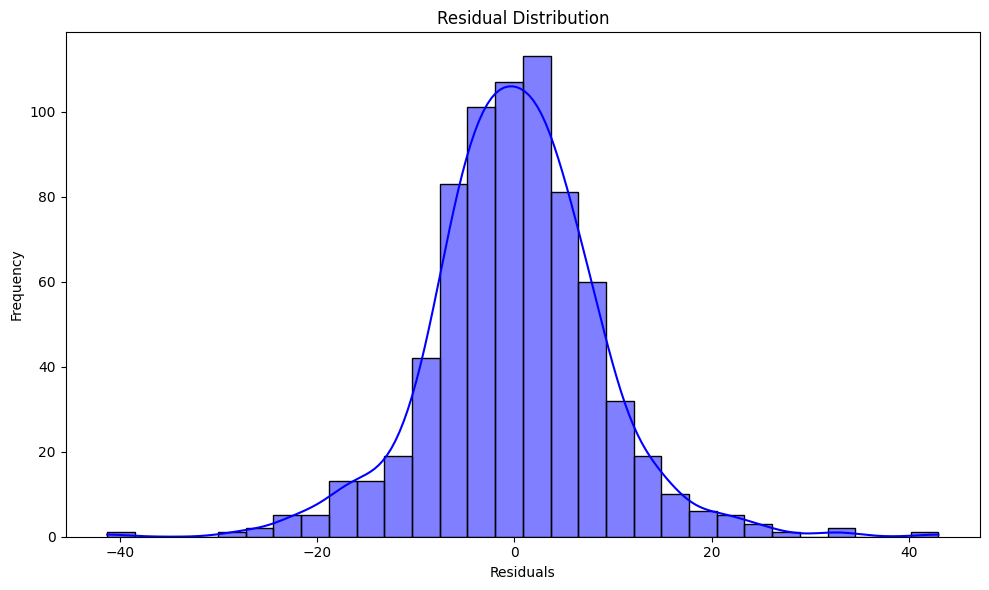

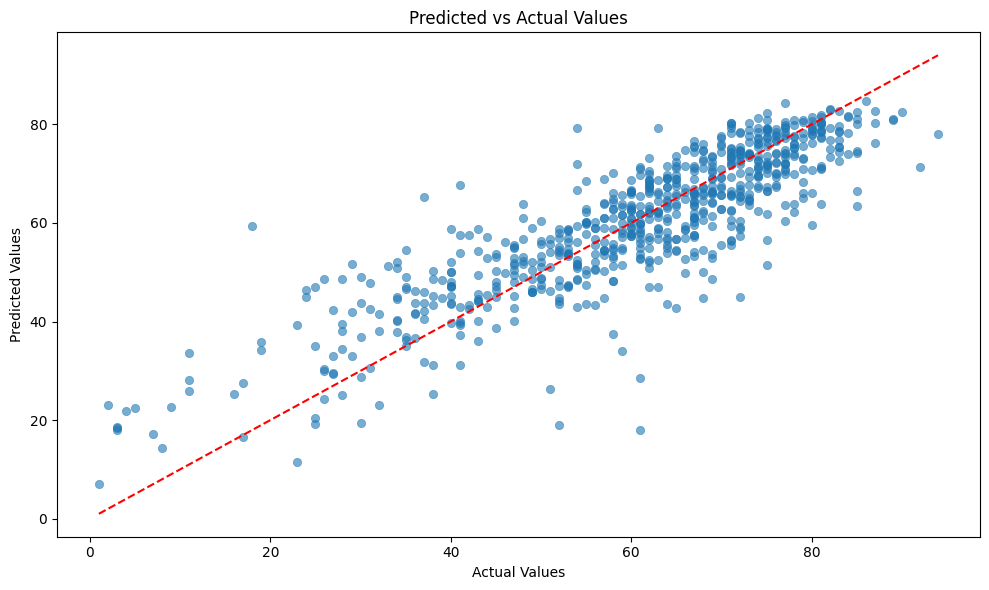

,Metric,Score
0,Mean Absolute Error,6.336001
1,Mean Squared Error,72.580153
2,Root Mean Squared Error,8.519399
3,R2 Score,0.743239


In [13]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


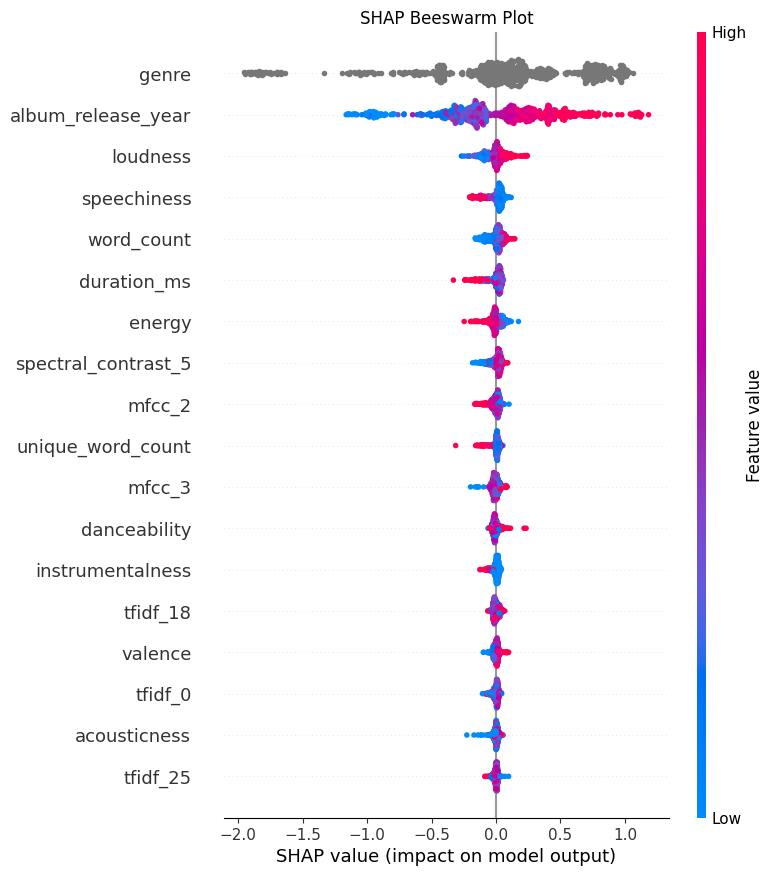

INFO: Generating feature importance bar plot...


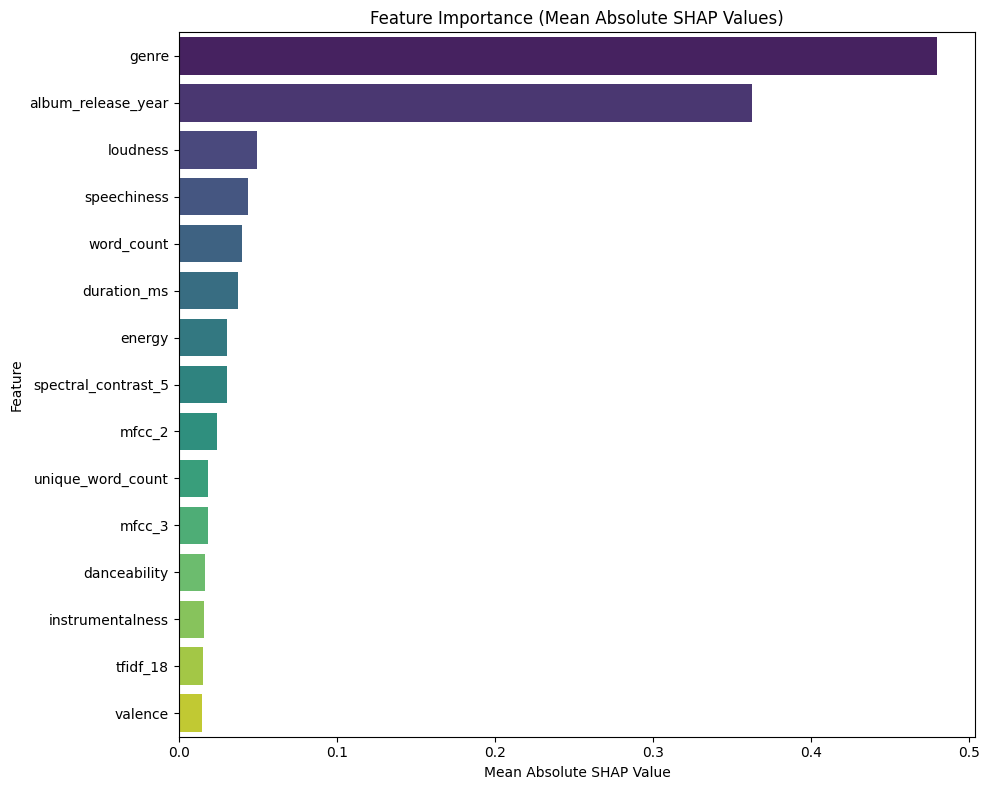

In [14]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [15]:
target = 'popularity'
features = lyrics_features + tfidf_features + w2v_features + empath_features

In [16]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [17]:
cat_features

['language']

In [18]:
len(num_features)

412

In [19]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['tfidf_38',
                                                                                                         'empath_medieval',
                                                                                                         'tfidf_81',
                                                                                                         'tfidf_60',
                                                                                                         'empath_sleep',
                                                                                                         'empath_liquid',
                                                                                                         'empath_ocea...
                                                                                                                                        handle_unknown='use_encoded_value',
                                                                                                                                        unknown_value=-1))]),
                                                                                                        ['language'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x706edff042b0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [20]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 23:12:57,761] A new study created in memory with name: catboost_optimization_e70147fc-6549-4ed2-af68-49c7a88b5221
[I 2024-12-20 23:14:17,793] Trial 3 finished with value: -0.7638129289536784 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.05958929841876018, 'l2_leaf_reg': 5.117394594538043}. Best is trial 3 with value: -0.7638129289536784.
[I 2024-12-20 23:14:20,015] Trial 2 finished with value: -0.7972053146270806 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.013610070397940686, 'l2_leaf_reg': 9.816220067276781}. Best is trial 3 with value: -0.7638129289536784.
[I 2024-12-20 23:15:43,228] Trial 8 finished with value: -0.7752317583150701 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.023263279154256848, 'l2_leaf_reg': 7.502342988430245}. Best is trial 3 with value: -0.7638129289536784.
[I 2024-12-20 23:19:04,803] Trial 0 finished with value: -0.7715237274276415 and parameters: {'iterations': 1000, 'depth': 6, 'le

INFO: Pipeline training completed.


In [21]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.681
1,MSE,0.763
2,RMSE,0.874
3,R2,0.235


INFO: Evaluating the regression model...


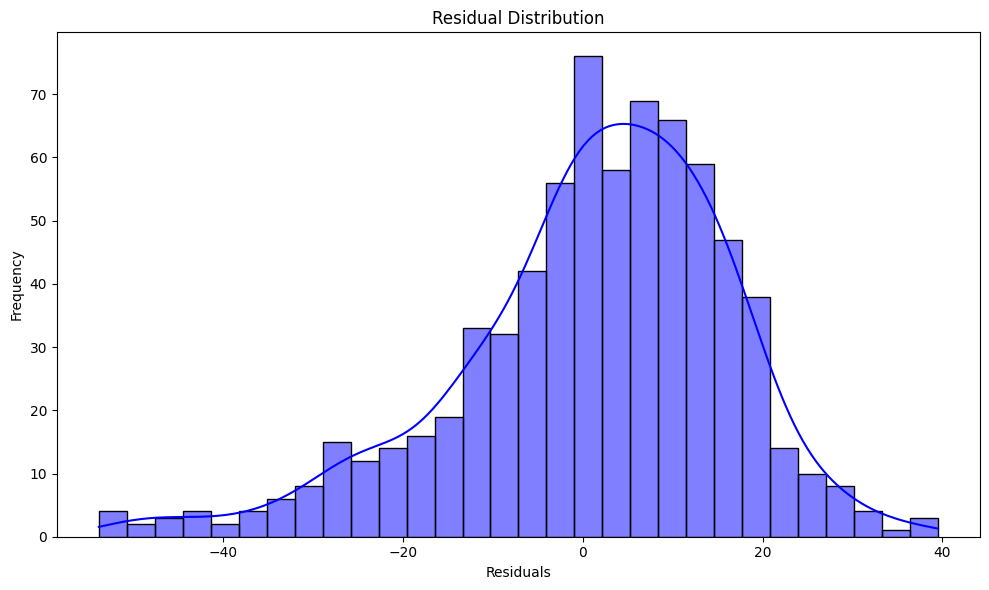

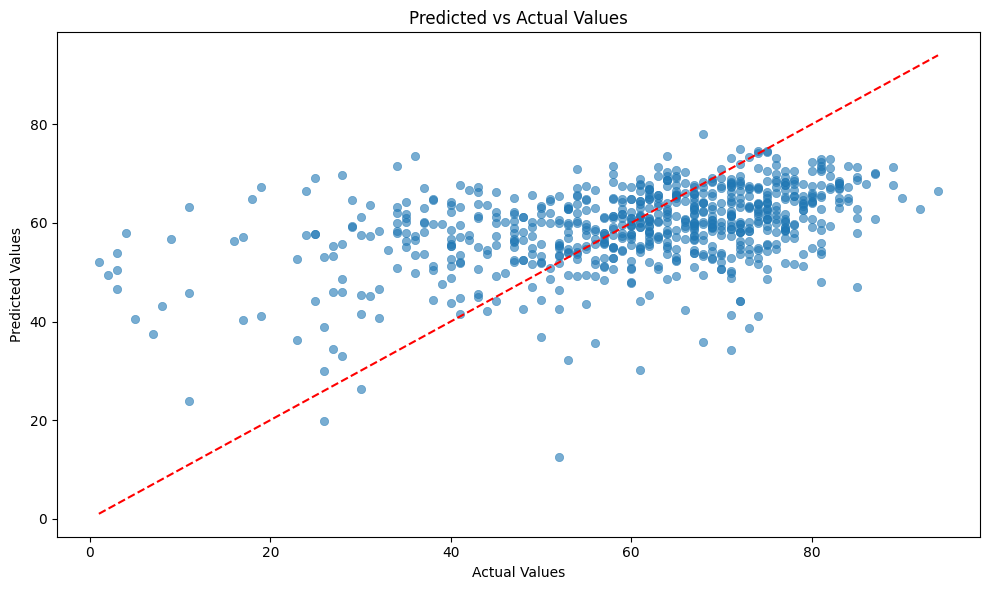

,Metric,Score
0,Mean Absolute Error,11.814888
1,Mean Squared Error,233.807778
2,Root Mean Squared Error,15.290774
3,R2 Score,0.172877


In [22]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


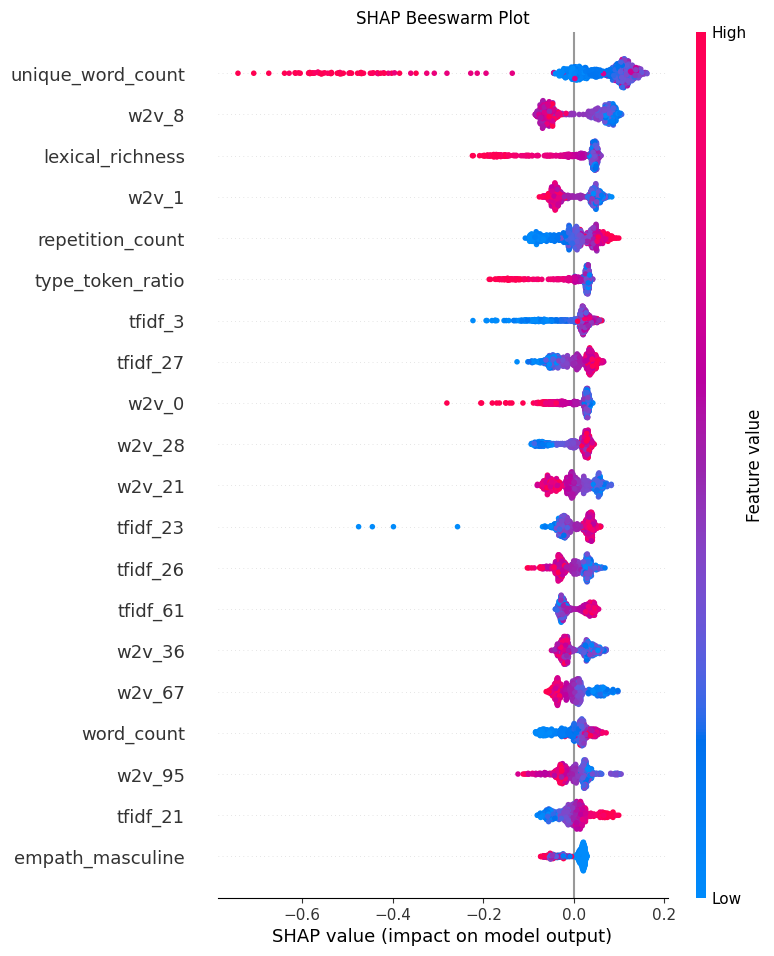

INFO: Generating feature importance bar plot...


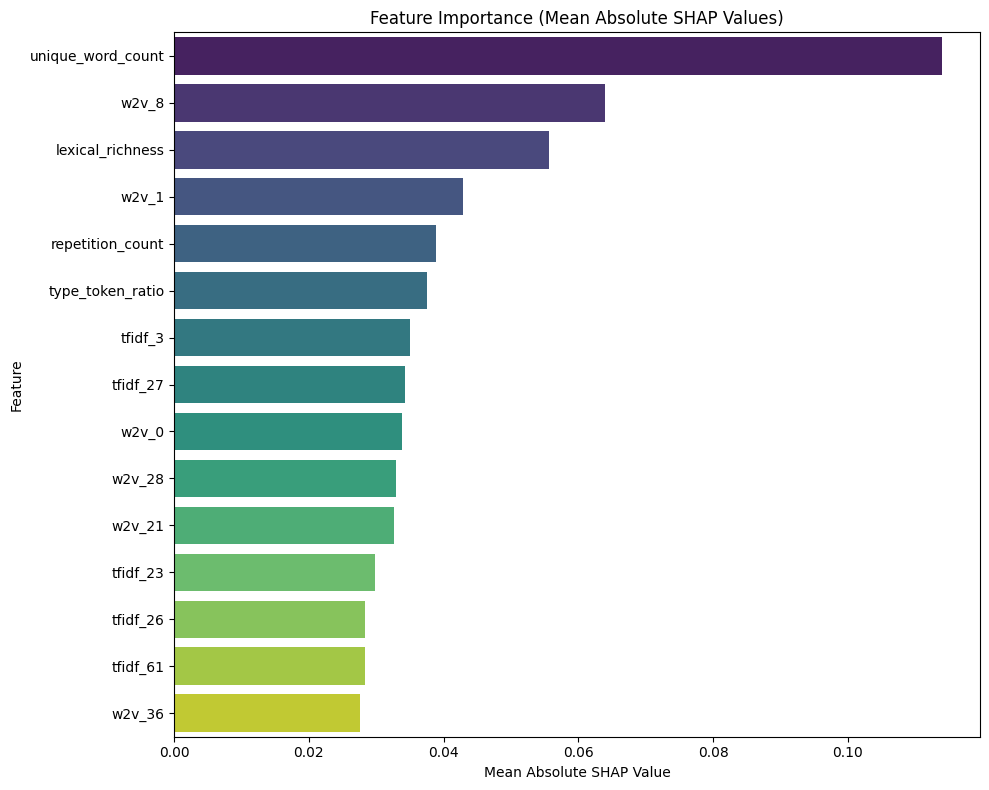

In [23]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [24]:
target = 'popularity'
features = spotify_features

In [25]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [26]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre']

In [27]:
len(num_features)

11

In [28]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['duration_ms',
                                                                                                         'liveness',
                                                                                                         'valence',
                                                                                                         'album_release_year',
                                                                                                         'danceability',
                                                                                                         'loudness',
                                                                                                         'instrumenta...
                                                                                                                                        unknown_value=-1))]),
                                                                                                        ['explicit',
                                                                                                         'genre',
                                                                                                         'mode',
                                                                                                         'key',
                                                                                                         'time_signature'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x706ee00c1210>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [29]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 23:24:00,556] A new study created in memory with name: catboost_optimization_65c1683e-5b38-4c42-a6a4-09953baef090
[I 2024-12-20 23:24:05,052] Trial 2 finished with value: -0.2047192428290487 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.04471703121576366, 'l2_leaf_reg': 2.4939246243312287}. Best is trial 2 with value: -0.2047192428290487.
[I 2024-12-20 23:24:06,735] Trial 7 finished with value: -0.19995908475739915 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.03243353581162623, 'l2_leaf_reg': 1.6601176119563381}. Best is trial 7 with value: -0.19995908475739915.
[I 2024-12-20 23:24:06,887] Trial 4 finished with value: -0.1991334803161841 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.0778591938777564, 'l2_leaf_reg': 5.075691732760294}. Best is trial 4 with value: -0.1991334803161841.
[I 2024-12-20 23:24:07,098] Trial 5 finished with value: -0.1996244757392394 and parameters: {'iterations': 500, 'depth': 6, 'le

INFO: Pipeline training completed.


In [30]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.337
1,MSE,0.198
2,RMSE,0.445
3,R2,0.802


INFO: Evaluating the regression model...


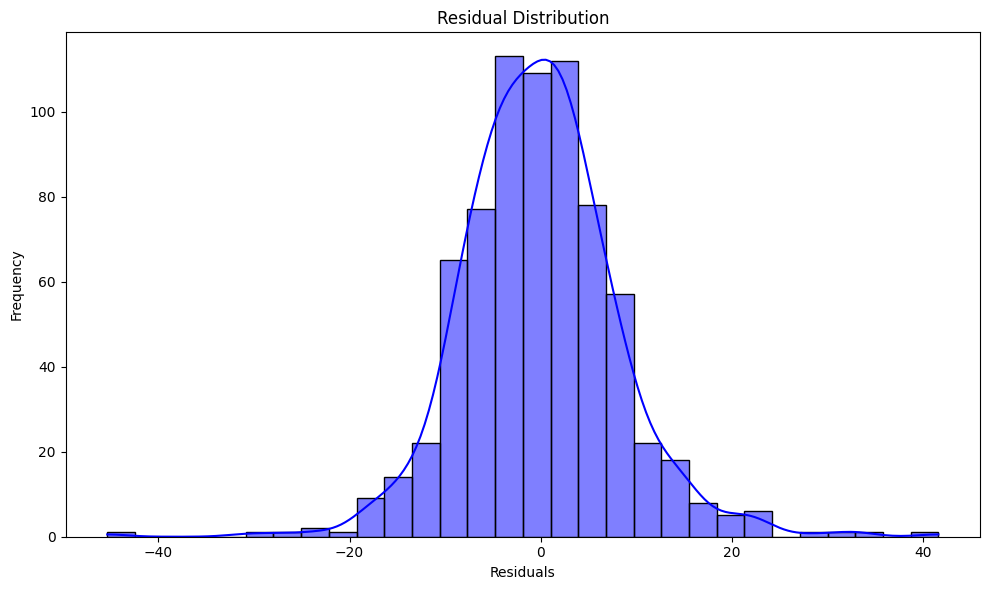

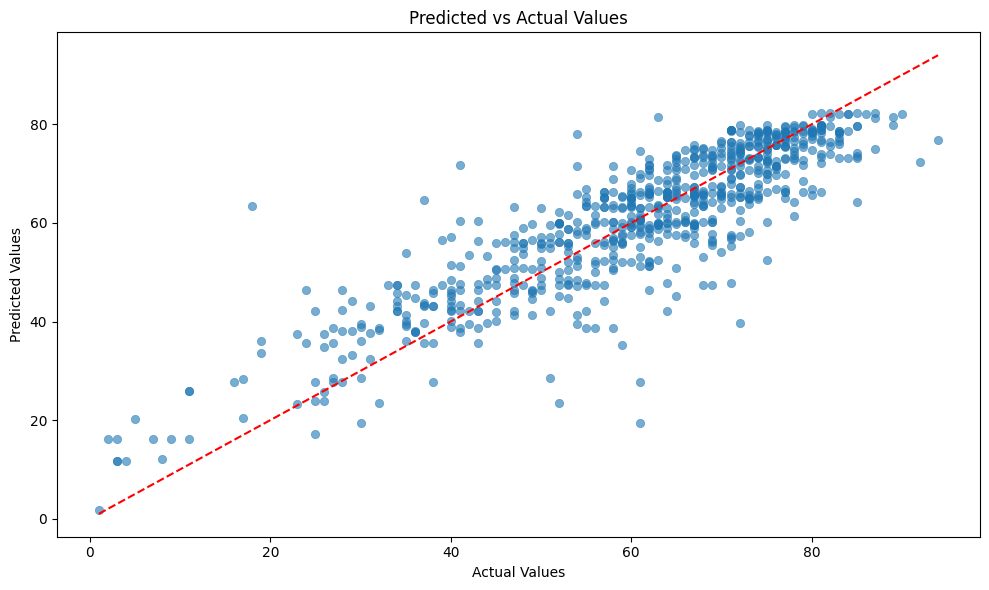

,Metric,Score
0,Mean Absolute Error,6.040872
1,Mean Squared Error,65.644993
2,Root Mean Squared Error,8.102160
3,R2 Score,0.767773


In [31]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


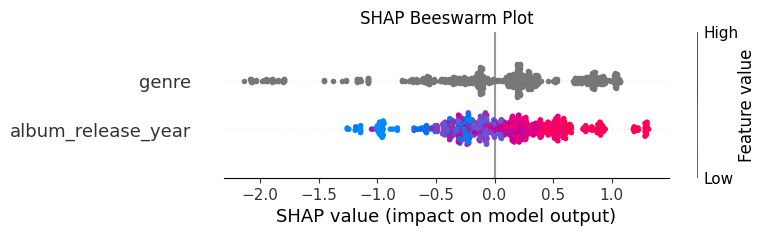

INFO: Generating feature importance bar plot...


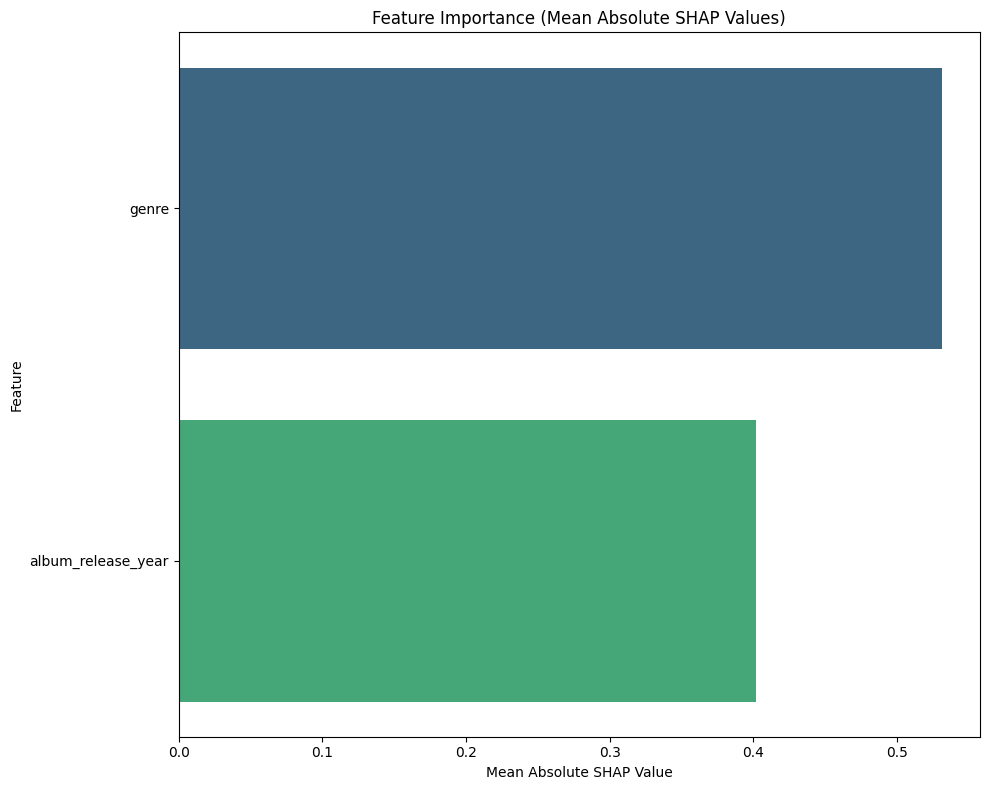

In [32]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [33]:
target = 'popularity'
features = audio_extracted_features

In [34]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [35]:
cat_features

[]

In [36]:
len(num_features)

34

In [37]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=[],
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['mfcc_10',
                                                                                                         'chroma_10',
                                                                                                         'chroma_7',
                                                                                                         'chroma_5',
                                                                                                         'chroma_8',
                                                                                                         'mfcc_8',
                                                                                                         'tempo_extracted',
                                                                                                         'mfcc_4',
                                                                                                         'mf...
                                                                                                                         OrdinalEncoder(dtype='object',
                                                                                                                                        handle_unknown='use_encoded_value',
                                                                                                                                        unknown_value=-1))]),
                                                                                                        [])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x706ee02074f0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [38]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 23:24:30,821] A new study created in memory with name: catboost_optimization_febeb4d9-7b7f-462a-840f-35ea8600ea7b
[I 2024-12-20 23:24:40,487] Trial 6 finished with value: -0.8571623442238062 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.07050461230534112, 'l2_leaf_reg': 7.588879666600438}. Best is trial 6 with value: -0.8571623442238062.
[I 2024-12-20 23:24:40,509] Trial 0 finished with value: -0.867594923009802 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.08553400933722179, 'l2_leaf_reg': 8.098428467804428}. Best is trial 6 with value: -0.8571623442238062.
[I 2024-12-20 23:24:41,150] Trial 5 finished with value: -0.8663713554996628 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.010631467062278311, 'l2_leaf_reg': 6.935247222751244}. Best is trial 6 with value: -0.8571623442238062.
[I 2024-12-20 23:24:49,144] Trial 4 finished with value: -0.8960448780734016 and parameters: {'iterations': 1000, 'depth': 4, 'lear

INFO: Pipeline training completed.


In [39]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.721
1,MSE,0.850
2,RMSE,0.922
3,R2,0.149


INFO: Evaluating the regression model...


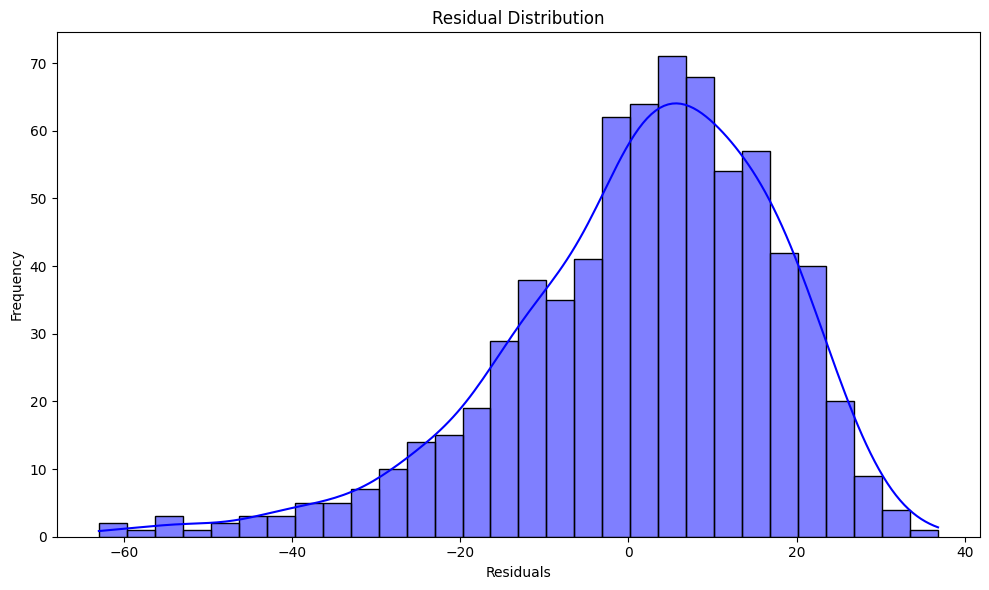

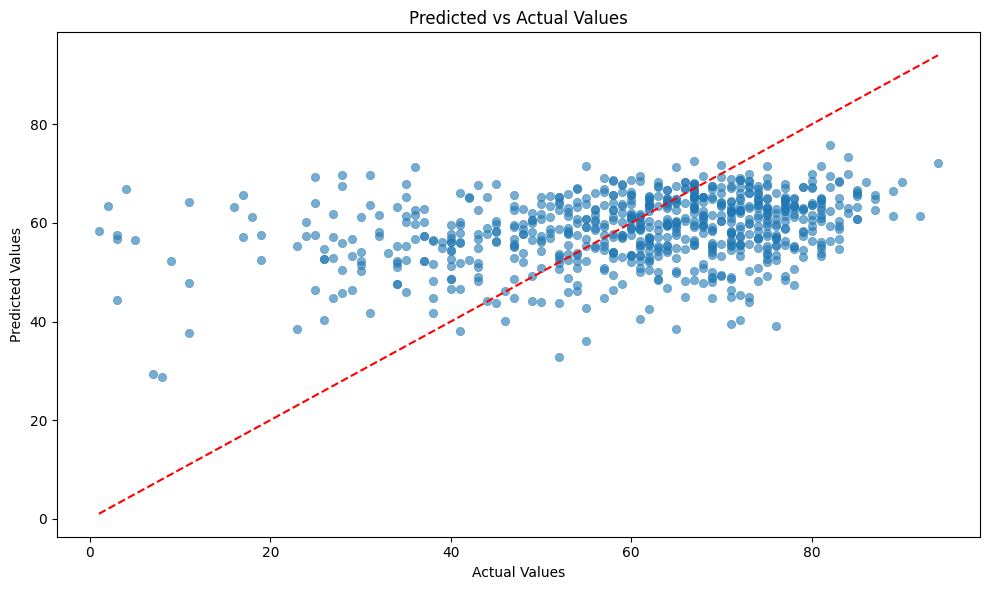

,Metric,Score
0,Mean Absolute Error,12.718090
1,Mean Squared Error,261.065416
2,Root Mean Squared Error,16.157519
3,R2 Score,0.076450


In [40]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


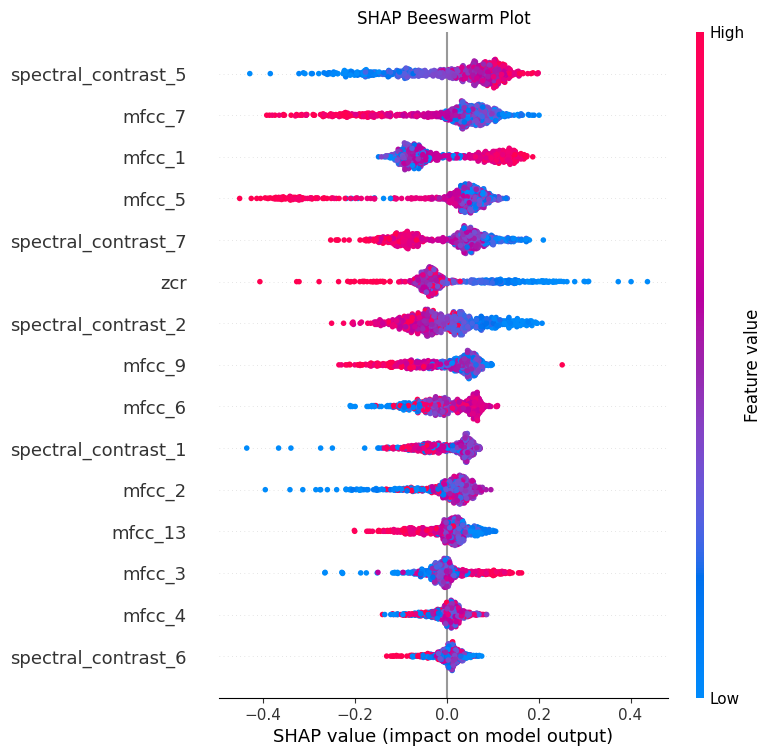

INFO: Generating feature importance bar plot...


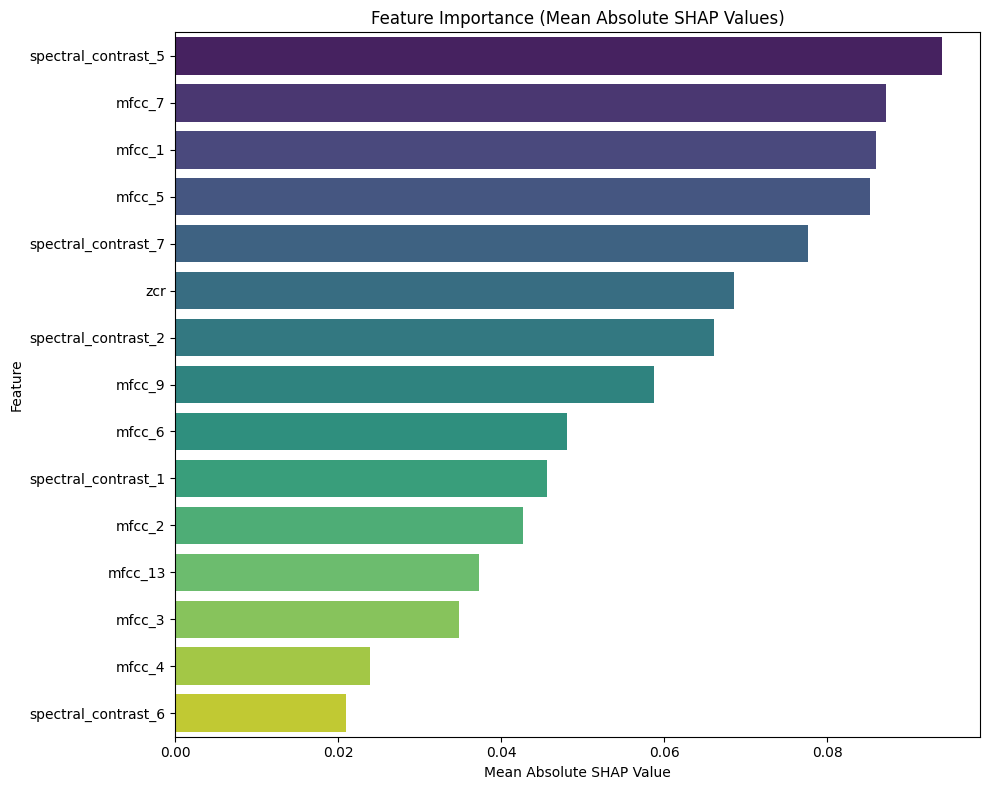

In [41]:
pipeline.perform_shap_analysis()

## Baseline

In [42]:
mean_model = MeanBaselineModel()
mean_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = mean_model.predict(pipeline.X_test)
mean_model.evaluate(pipeline.y_test, y_pred)

,Score
MAE,13.532726
MSE,285.647024
RMSE,16.901095
R2,-0.010510


# Classification

In [43]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")

Loaded 3621 songs


In [44]:
df['popularity_binary'] = df.popularity.apply(lambda x: x >= df.popularity.quantile(0.7)).astype(int)
df['popularity_binary'].value_counts()

popularity_binary
0    2464
1    1157
Name: count, dtype: int64

In [45]:
df.popularity.quantile(0.7)

70.0

In [46]:
df = df.drop('popularity', axis=1)

## Prediction with all features

In [47]:
target = 'popularity_binary'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [48]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [49]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre', 'language']

In [50]:
len(num_features)

457

In [51]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tfidf_38',
                                                                    'empath_medieval',
                                                                    'tfidf_81',
                                                                    'tfidf_60',
                                                                    'empath_sleep',
                                                                    'empath_liquid',
                                                                    'empath_ocean',
                                                                    'empath_vacation',
                                                                    'empath_kill',
                                                                    't...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['explicit',
                                                                    'genre',
                                                                    'mode',
                                                                    'language',
                                                                    'key',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x706ee126ca90>)])

In [52]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 23:25:31,918] A new study created in memory with name: catboost_popularity_binary
[I 2024-12-20 23:27:36,882] Trial 0 finished with value: 0.8574342871399079 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.011223050758584714, 'l2_leaf_reg': 2.619850531825767}. Best is trial 0 with value: 0.8574342871399079.
[I 2024-12-20 23:27:41,601] Trial 5 finished with value: 0.8624223823014121 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.03744863666655803, 'l2_leaf_reg': 8.089661979516277}. Best is trial 5 with value: 0.8624223823014121.
[I 2024-12-20 23:29:58,072] Trial 9 finished with value: 0.8556371868928793 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.014623288636133396, 'l2_leaf_reg': 6.65531587459426}. Best is trial 5 with value: 0.8624223823014121.
[I 2024-12-20 23:30:23,458] Trial 7 finished with value: 0.8656186793811955 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.08682839569556158, 'l2_le

INFO: Pipeline training completed.


In [53]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.87
1,F1 Score,0.87
2,Precision,0.87
3,Recall,0.87


INFO: Evaluating the model...


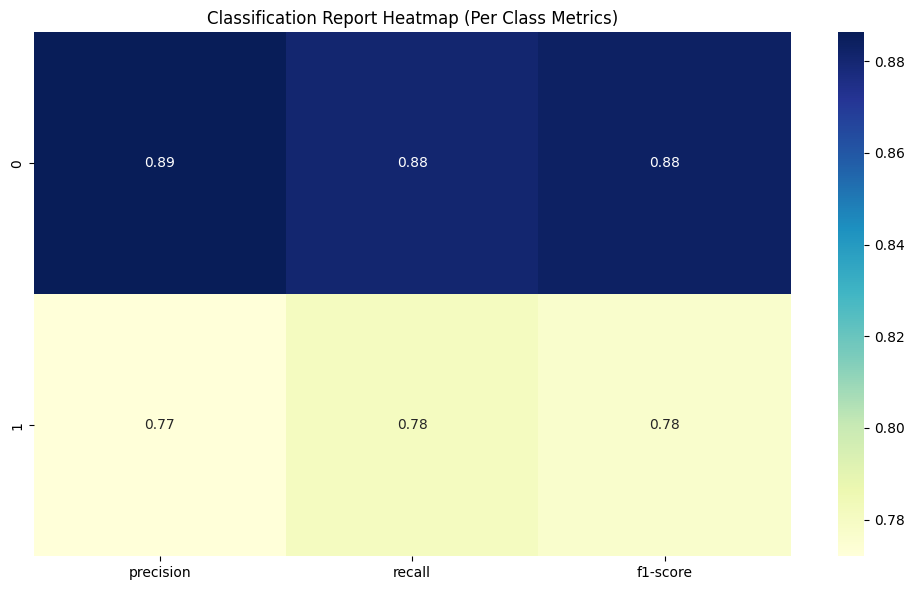

,precision,recall,f1-score,support
0,0.886316,0.880753,0.883526,478.000000
1,0.772000,0.781377,0.776660,247.000000
accuracy,0.846897,0.846897,0.846897,0.846897
macro avg,0.829158,0.831065,0.830093,725.000000
weighted avg,0.847370,0.846897,0.847118,725.000000


In [54]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


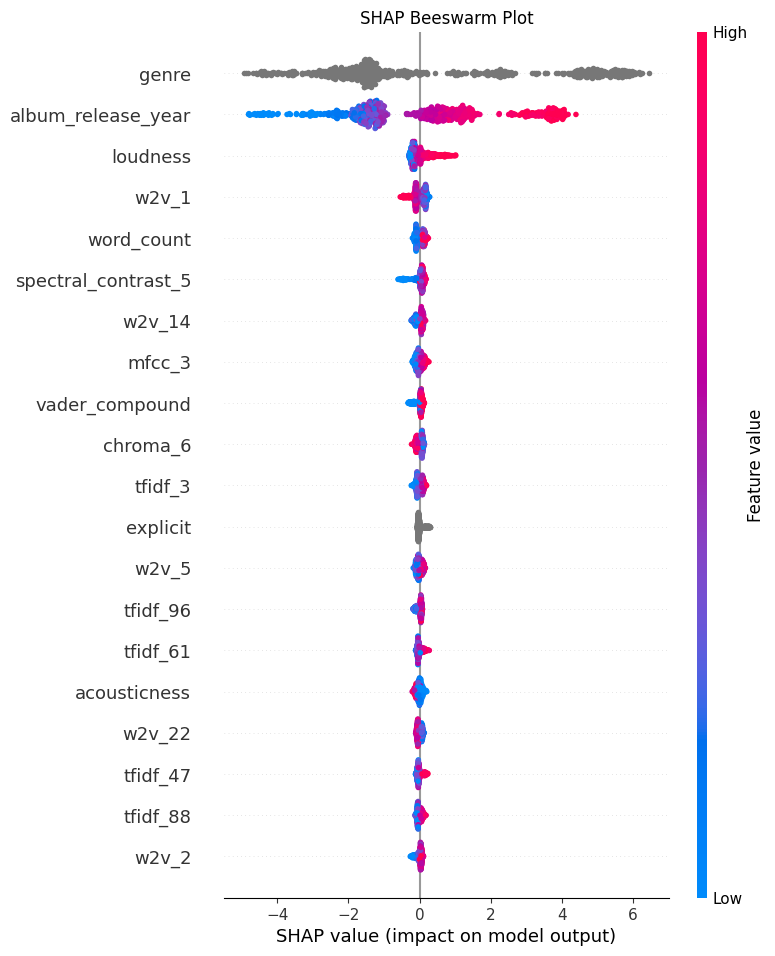

INFO: Generating feature importance bar plot...


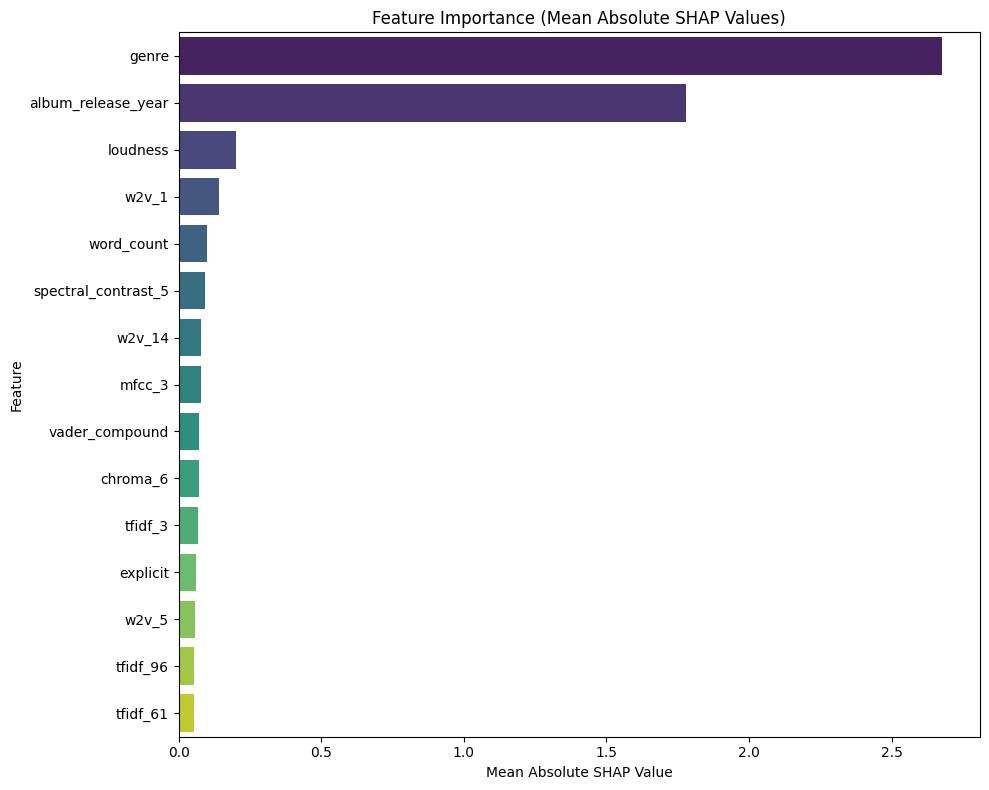

In [55]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [56]:
target = 'popularity_binary'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [57]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [58]:
cat_features

['language']

In [59]:
len(num_features)

412

In [60]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tfidf_38',
                                                                    'empath_medieval',
                                                                    'tfidf_81',
                                                                    'tfidf_60',
                                                                    'empath_sleep',
                                                                    'empath_liquid',
                                                                    'empath_ocean',
                                                                    'empath_vacation',
                                                                    'empath_kill',
                                                                    't...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['language'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x706ed4d10340>)])

In [61]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 23:40:23,254] A new study created in memory with name: catboost_popularity_binary
[I 2024-12-20 23:42:21,670] Trial 4 finished with value: 0.6729195683689462 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.08357195332659838, 'l2_leaf_reg': 3.344945450411192}. Best is trial 4 with value: 0.6729195683689462.
[I 2024-12-20 23:44:19,507] Trial 6 finished with value: 0.6698304988950315 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.040615884588397974, 'l2_leaf_reg': 2.8211038887545685}. Best is trial 4 with value: 0.6729195683689462.
[I 2024-12-20 23:44:22,189] Trial 0 finished with value: 0.6671113837996134 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.09868766551928983, 'l2_leaf_reg': 6.225799959733003}. Best is trial 4 with value: 0.6729195683689462.
[I 2024-12-20 23:44:56,852] Trial 1 finished with value: 0.6832202867909325 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.037927331986301785, 'l

INFO: Pipeline training completed.


In [62]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.700
1,F1 Score,0.683
2,Precision,0.681
3,Recall,0.700


INFO: Evaluating the model...


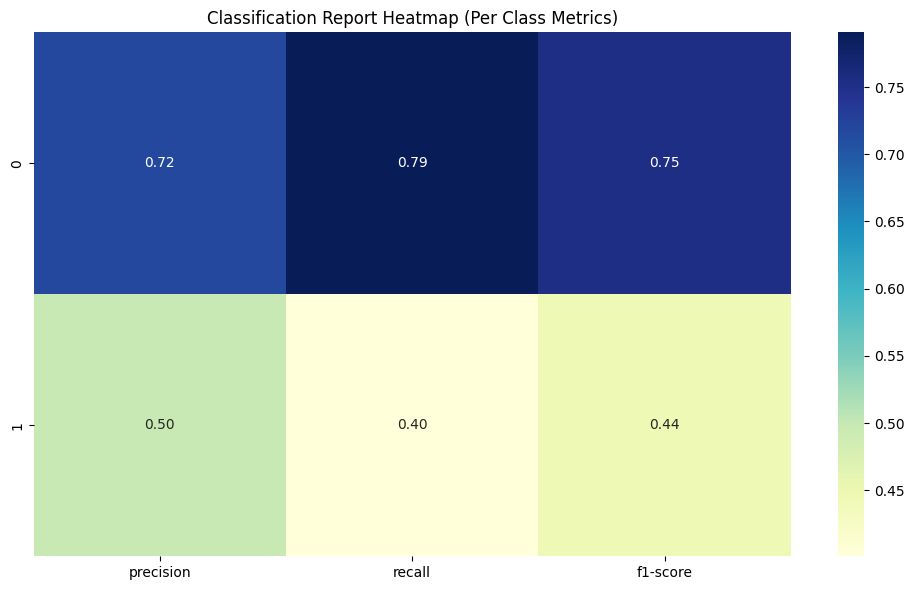

,precision,recall,f1-score,support
0,0.718631,0.790795,0.752988,478.000000
1,0.497487,0.400810,0.443946,247.000000
accuracy,0.657931,0.657931,0.657931,0.657931
macro avg,0.608059,0.595802,0.598467,725.000000
weighted avg,0.643290,0.657931,0.647701,725.000000


In [63]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


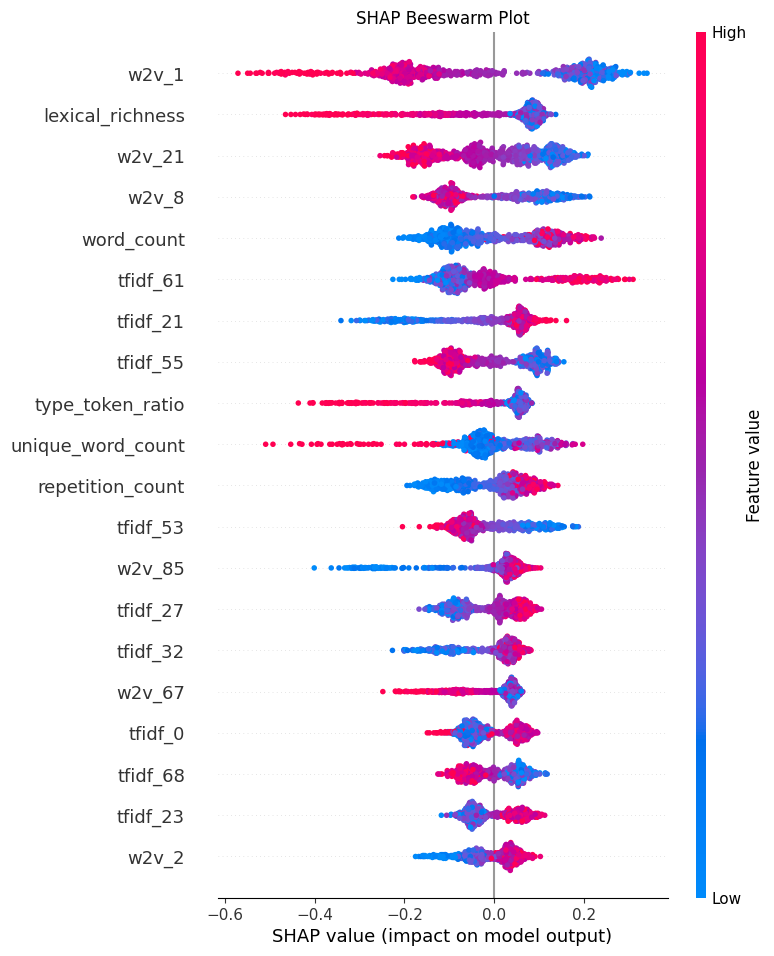

INFO: Generating feature importance bar plot...


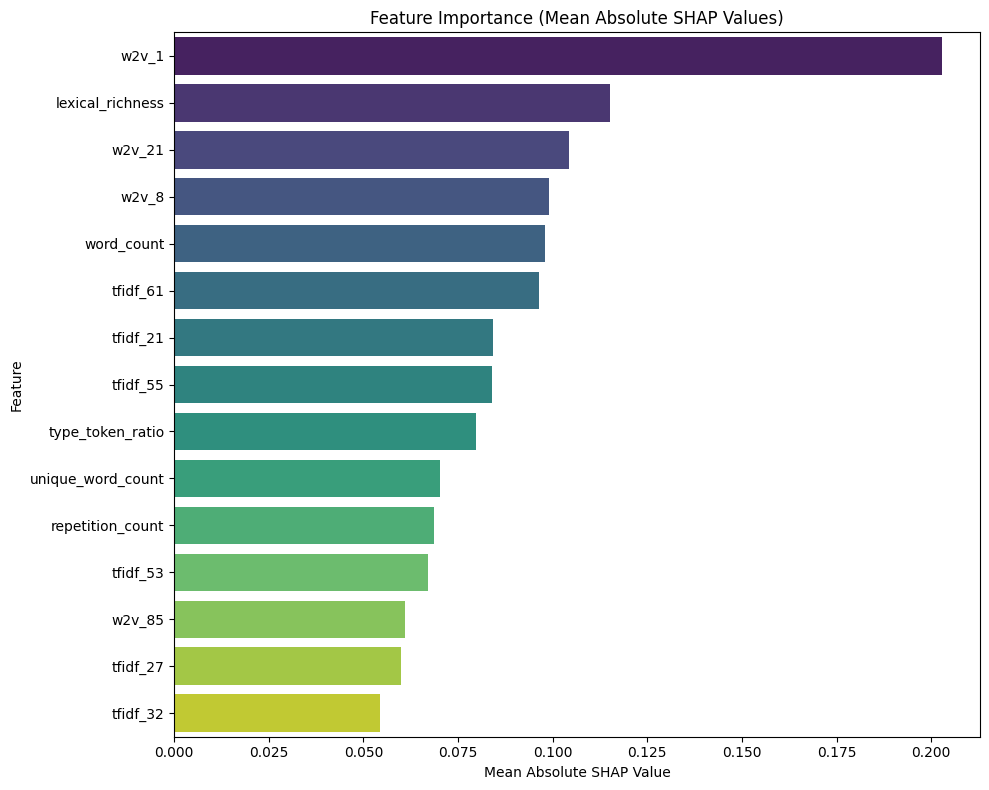

In [64]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [65]:
target = 'popularity_binary'
features = [ f for f in spotify_features if f in df.columns ]

In [66]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [67]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre']

In [68]:
len(num_features)

11

In [69]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['duration_ms',
                                                                    'liveness',
                                                                    'valence',
                                                                    'album_release_year',
                                                                    'danceability',
                                                                    'loudness',
                                                                    'instrumentalness',
                                                                    'energy',
                                                                    'acousticness',
                                                                    'speec...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['explicit',
                                                                    'genre',
                                                                    'mode',
                                                                    'key',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x706ee0123b50>)])

In [70]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 23:54:49,129] A new study created in memory with name: catboost_popularity_binary
[I 2024-12-20 23:55:01,871] Trial 3 finished with value: 0.8571309642449307 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.06940477837759428, 'l2_leaf_reg': 6.246777201543037}. Best is trial 3 with value: 0.8571309642449307.
[I 2024-12-20 23:55:02,183] Trial 5 finished with value: 0.8514623422353467 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.07837861229632287, 'l2_leaf_reg': 2.3074908524633395}. Best is trial 3 with value: 0.8571309642449307.
[I 2024-12-20 23:55:03,953] Trial 1 finished with value: 0.851857316040752 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.07866476803923425, 'l2_leaf_reg': 8.473443345298804}. Best is trial 3 with value: 0.8571309642449307.
[I 2024-12-20 23:55:04,607] Trial 4 finished with value: 0.8575532341947232 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.09623325325558374, 'l2_lea

INFO: Pipeline training completed.


In [71]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.857
1,F1 Score,0.858
2,Precision,0.860
3,Recall,0.857


INFO: Evaluating the model...


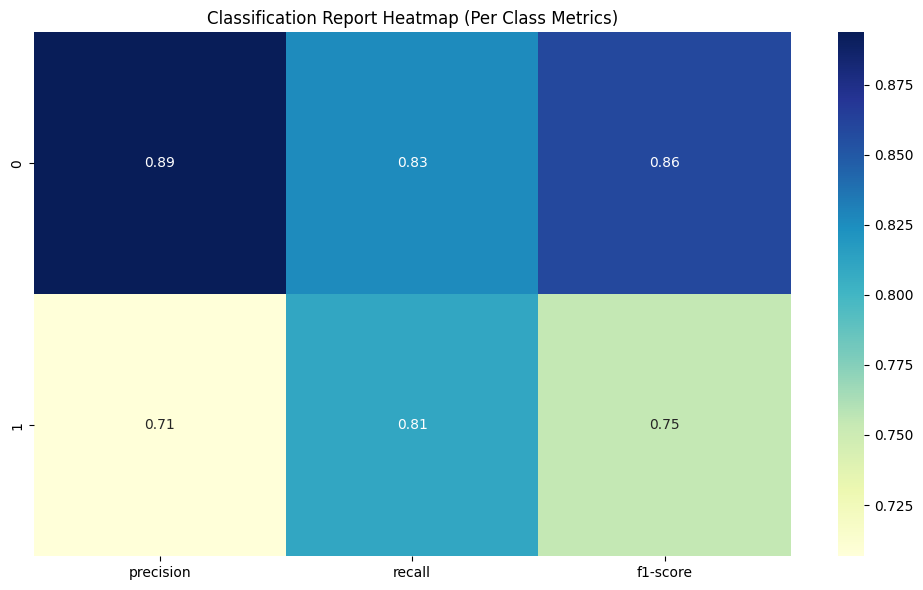

,precision,recall,f1-score,support
0,0.893665,0.826360,0.858696,478.00000
1,0.706714,0.809717,0.754717,247.00000
accuracy,0.820690,0.820690,0.820690,0.82069
macro avg,0.800189,0.818038,0.806706,725.00000
weighted avg,0.829973,0.820690,0.823271,725.00000


In [72]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


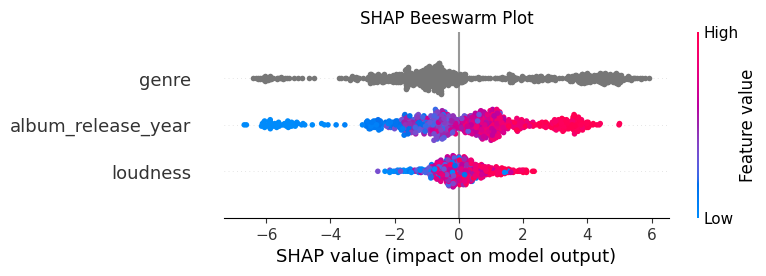

INFO: Generating feature importance bar plot...


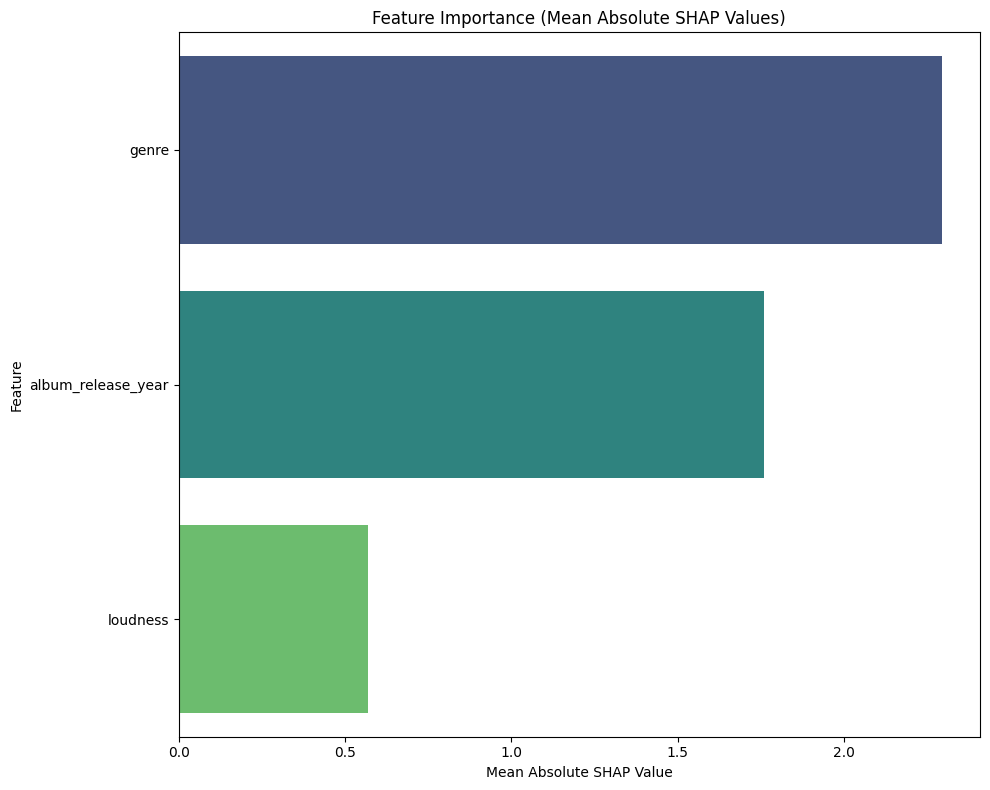

In [73]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [74]:
target = 'popularity_binary'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [75]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [76]:
cat_features

[]

In [77]:
len(num_features)

34

In [78]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['mfcc_10',
                                                                    'chroma_10',
                                                                    'chroma_7',
                                                                    'chroma_5',
                                                                    'chroma_8',
                                                                    'mfcc_8',
                                                                    'tempo_extracted',
                                                                    'mfcc_4',
                                                                    'mfcc_11',
                                                                    'chroma_2',
                                                                    'chroma_3',
                                                                    'chroma_...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   [])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x706ee13a1ea0>)])

In [79]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 23:55:32,130] A new study created in memory with name: catboost_popularity_binary
[I 2024-12-20 23:55:41,933] Trial 0 finished with value: 0.6553003313892355 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.06030210370827986, 'l2_leaf_reg': 5.631939768495711}. Best is trial 0 with value: 0.6553003313892355.
[I 2024-12-20 23:55:50,393] Trial 1 finished with value: 0.6719872495228036 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.08507689530257312, 'l2_leaf_reg': 4.398733045287456}. Best is trial 1 with value: 0.6719872495228036.
[I 2024-12-20 23:55:52,701] Trial 2 finished with value: 0.6498793158457252 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.011769534601392373, 'l2_leaf_reg': 3.749140825315077}. Best is trial 1 with value: 0.6719872495228036.
[I 2024-12-20 23:55:53,184] Trial 5 finished with value: 0.6575149019059132 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.021136429587337746, 'l2

INFO: Pipeline training completed.


In [80]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.675
1,F1 Score,0.672
2,Precision,0.670
3,Recall,0.675


INFO: Evaluating the model...


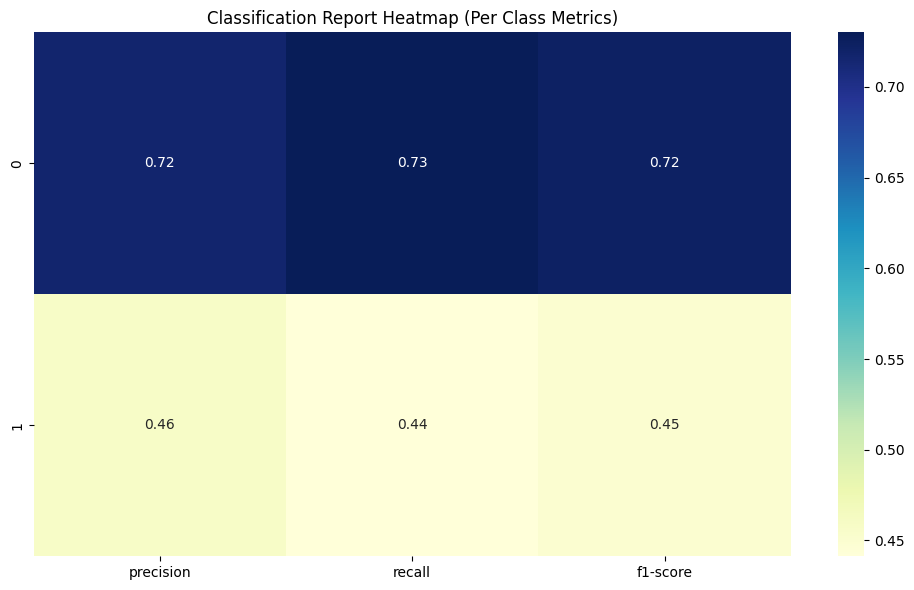

,precision,recall,f1-score,support
0,0.716632,0.730126,0.723316,478.000000
1,0.457983,0.441296,0.449485,247.000000
accuracy,0.631724,0.631724,0.631724,0.631724
macro avg,0.587308,0.585711,0.586400,725.000000
weighted avg,0.628513,0.631724,0.630024,725.000000


In [81]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


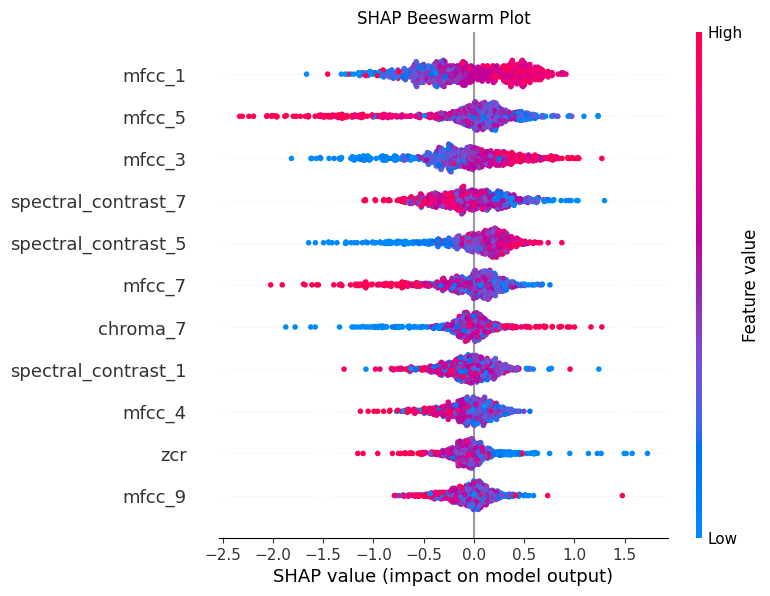

INFO: Generating feature importance bar plot...


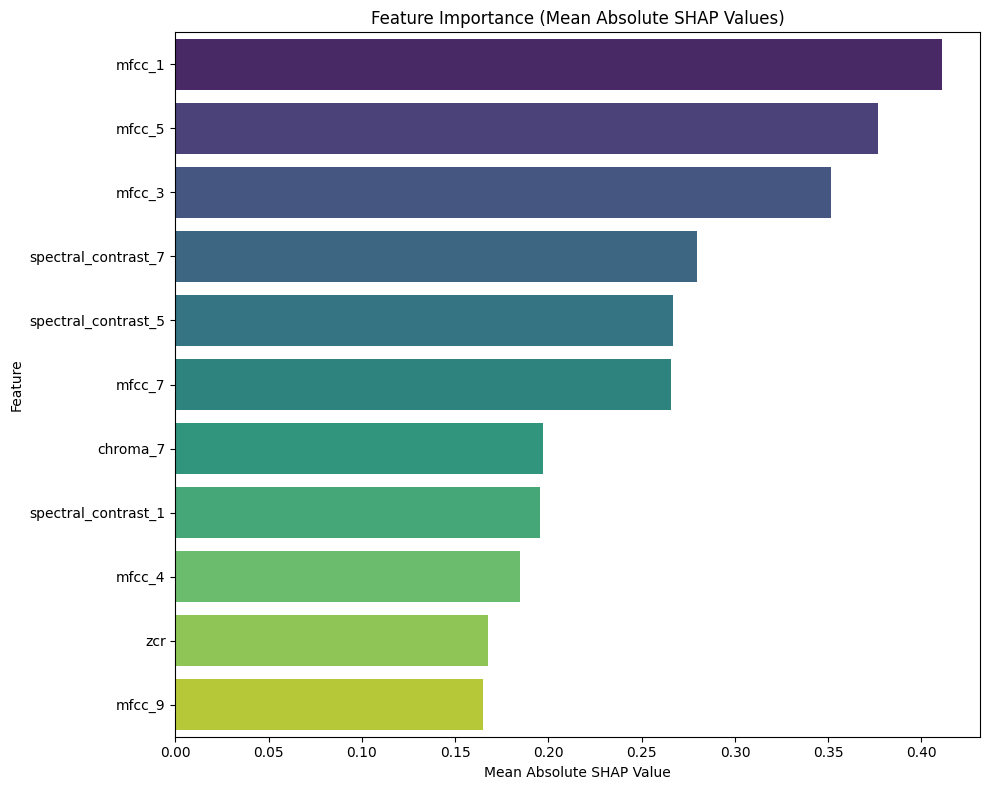

In [82]:
pipeline.perform_shap_analysis()

## Baseline

In [83]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.659310
Precision,0.434690
Recall,0.659310
F1 Score,0.523941


In [84]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.482759
Precision,0.541914
Recall,0.482759
F1 Score,0.495740
